<a href="https://colab.research.google.com/github/kozz84/particle_analysis/blob/main/Article_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import scipy
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import seaborn as sns
import scipy.stats
from skimage import io,morphology
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table,perimeter
from skimage.color import label2rgb

Mounted at /content/drive


In [2]:
df = pd.read_csv("/content/drive/MyDrive/CIOP/images/df.csv")

In [3]:
df.head()

,mean_intensity,area,extent,eccentricity,convex_area,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,feret_diameter_max,...,convex_image,img,convex_perimeter,circularity,aspect_ratio,solidity,convexity,filename,area_fraction,label
0,44.255319,578.356287,0.380567,0.775433,892.145337,27.136435,40.826682,25.779193,125.667879,50.225669,...,[[False False True False False False False Fa...,"[array([[ 96, 97, 99, 95, 85, 93, 84, 8...",125.491598,0.678388,0.631430,0.648276,0.998597,210902_#1_50_10_1um_i004.tif,516.940327,0
1,13.791667,295.330870,0.500000,0.811877,393.774493,19.391414,28.140599,16.429302,84.262928,31.375727,...,[[False False False False False False False Fa...,"[array([[111, 113, 106, 111, 114, 105, 89, 10...",74.766633,0.722974,0.583829,0.750000,0.887302,210902_#1_50_10_1um_i004.tif,263.969529,0
2,16.066667,276.872691,0.441176,0.951442,430.690852,18.775656,40.863839,12.579055,83.059202,42.240865,...,[[False False False False True True True T...,"[array([[ 81, 83, 98, 93, 117, 114, 105, 9...",83.059202,0.710162,0.307829,0.642857,1.000000,210902_#1_50_10_1um_i004.tif,247.471433,0
3,34.584337,1021.352592,0.399038,0.834056,1839.665212,36.061427,63.447555,35.002771,232.166887,66.187168,...,[[False False False False False False False Fa...,"[array([[101, 109, 100, 95, 109, 116, 116, 11...",175.189118,0.487969,0.551680,0.555184,0.754583,210902_#1_50_10_1um_i004.tif,912.894621,0
4,15.392857,344.552682,0.388889,0.870760,584.509014,20.945121,36.982017,18.184369,107.526452,39.996361,...,[[False False False False False False True T...,"[array([[109, 109, 117, 110, 109, 98, 108, 11...",93.759223,0.611952,0.491708,0.589474,0.871964,210902_#1_50_10_1um_i004.tif,307.964450,0


In [5]:
skew = pd.DataFrame(df.select_dtypes(np.number).columns, columns=['Feature'])
skew['skew'] = scipy.stats.skew(df.select_dtypes(np.number))
skew['skew_abs'] = skew['skew'].apply(abs)
skew['skewed'] = skew['skew_abs'].apply(lambda x: True if x>=0.5 else False)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocessing(df):
    temp = df[(df['equivalent_diameter']>0)].copy()
    temp = temp[temp['filename']!= '210902_#9_150_30_1um_i005']
    file_col = pd.DataFrame(columns=['filename'])
    file_col['filename'] = temp['filename'].copy()
    for column in skew.query('skewed == True')['Feature'].values:
        temp[column] = np.log1p(temp[column])
    y = temp['label']
    X = temp.drop(['filename','label','image','convex_image','img'],axis=1)
    X_df = X.copy()
    scaler = StandardScaler()
    columns_names = X.columns
    X = scaler.fit_transform(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,shuffle=True)
    return X,y,X_train,X_test,y_train,y_test, file_col,columns_names,X_df
X,y,X_train,X_test,y_train,y_test,file_col,columns_names,X_df = preprocessing(df)

In [7]:
from sklearn.cluster import SpectralClustering, KMeans,AgglomerativeClustering,DBSCAN
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score

In [8]:
cluster_models = {
    'Spectral Clustering':SpectralClustering(n_clusters=2,
                            affinity='nearest_neighbors',
                            assign_labels='kmeans',
                            random_state=464
                            ),
    'Spectral Biclustering': KMeans(n_clusters=2),
    'AgglomerativeClustering':AgglomerativeClustering(),
    "DBSCAN":DBSCAN(eps=9.7, min_samples=2, algorithm='ball_tree', metric='minkowski', leaf_size=90, p=2)
}

cluster_score = []
cluster_results = pd.DataFrame()
cluster_results['true'] = y
for name,cluster_model in cluster_models.items():
    cluster_model.fit(X)
    print(confusion_matrix(y,cluster_model.labels_))
    cluster_score.append([name,accuracy_score(y,cluster_model.labels_)])
    cluster_results[name] = cluster_model.labels_
cluster_score = pd.DataFrame(cluster_score, columns=['model name', 'Accuracy'])
cluster_score.sort_values('Accuracy',ascending=False)

[[1488 4437]
 [1649 4024]]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[1847 4078]
 [1896 3777]]
[[2411 3514]
 [2240 3433]]
[[5925    0]
 [5673    0]]


,model name,Accuracy
3,DBSCAN,0.510864
2,AgglomerativeClustering,0.503880
1,Spectral Biclustering,0.484911
0,Spectral Clustering,0.475254


In [10]:
def NN_model():
    model = Sequential()
    model.add(Dense(16,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(4,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer = 'adam',
                loss='binary_crossentropy')
    early_stop = EarlyStopping(monitor='val_loss', 
                            mode='min',
                            verbose=1,
                            patience=25)
    return model
y.value_counts()

0    5925
1    5673
Name: label, dtype: int64

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
model = Sequential()
model.add(Dense(17,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam',
              loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           verbose=1,
                           patience=25)

In [13]:
for i in range (10):
    X,y,X_train,X_test,y_train,y_test,file_col,columns_names,X_df = preprocessing(df)
    NN_model()
    model.fit(X_train,
          y_train,
          epochs=250,
          validation_data=(X_test,y_test),
          callbacks=[early_stop],
          verbose=0)
    y_pred = pd.DataFrame((model.predict(X) > 0.5).astype("int32"))
    print(i,accuracy_score(y,y_pred))
    print(confusion_matrix(y,y_pred))

Epoch 138: early stopping
363/363 [==============================] - 1s 1ms/step
0 0.9568891188135885
[[5764  161]
 [ 339 5334]]
Epoch 26: early stopping
363/363 [==============================] - 1s 2ms/step
1 0.9498189342990171
[[5510  415]
 [ 167 5506]]
Epoch 26: early stopping
363/363 [==============================] - 0s 1ms/step
2 0.9568891188135885
[[5757  168]
 [ 332 5341]]
Epoch 44: early stopping
363/363 [==============================] - 0s 1ms/step
3 0.9570615623383342
[[5700  225]
 [ 273 5400]]
Epoch 26: early stopping
363/363 [==============================] - 0s 1ms/step
4 0.9619762027935851
[[5690  235]
 [ 206 5467]]
Epoch 26: early stopping
363/363 [==============================] - 1s 2ms/step
5 0.9597344369718918
[[5793  132]
 [ 335 5338]]
Epoch 31: early stopping
363/363 [==============================] - 0s 1ms/step
6 0.9633557509915502
[[5770  155]
 [ 270 5403]]
Epoch 26: early stopping
363/363 [==============================] - 1s 2ms/step
7 0.9636144162786687
[[

In [14]:
model = Sequential()
model.add(Dense(16,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam',
              loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           verbose=1,
                           patience=25)

model.fit(X_train,
          y_train,
          epochs=250,
          validation_data=(X_test,y_test),
          callbacks=[early_stop],
          verbose=0)

Epoch 174: early stopping


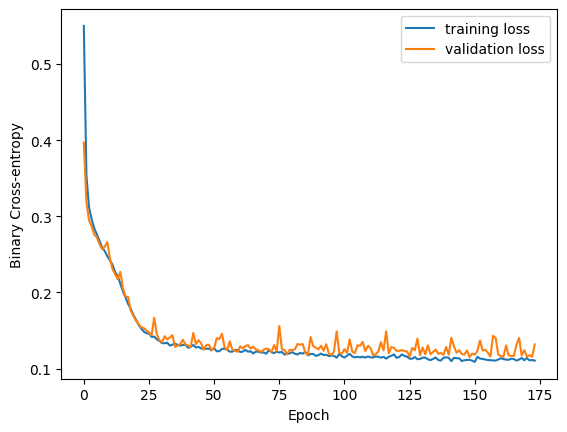

In [15]:
history = pd.DataFrame(model.history.history)
plt.plot(history)
plt.ylabel('Binary Cross-entropy')
plt.xlabel('Epoch')
plt.gca().legend(('training loss','validation loss'))

In [16]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame((model.predict(X_test) > 0.5).astype("int32"))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred)) 
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

109/109 [==============================] - 0s 1ms/step
0.9459770114942528
[[1686   79]
 [ 109 1606]]
F1 Score: 0.945
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1765
           1       0.95      0.94      0.94      1715

    accuracy                           0.95      3480
   macro avg       0.95      0.95      0.95      3480
weighted avg       0.95      0.95      0.95      3480

